# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPdfdfdRjJXXXXX' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcdfdfdjD3dKBe682Yt2MOiNv6bXXXX' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24dfdfdfvBgwXKyPi5bXXXX' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEdfdfdfYDS9VfIzOboQoXXXX'<br />

## Modulo para autenticação no twitter

In [1]:
!ls *.txt

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [3]:
#!pip install twitter
#!pip install pymongo

In [5]:
!type tokens.txt

DcPtlOYZ07jilc3PgYJLUPRjJ
bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b
2904474861-qPmMjcwisBQWR1cMILoXevC8QeKS3Go3PzN5lBq
h0iaWqpk7YqsP9MAk5mU472ZOsFOtunfL76fwhEY3x9PA


## Leitura das chaves de acesso

In [6]:
def ler_tokens_acesso():
    filename = 'tokens.txt'
    with open(filename) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    return content[0], content[1], content[2], content[3]

#CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
#print(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# Twitter

In [7]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    #CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUdfdfdfJ'
    #CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOdfdf'
    
    #OAUTH_TOKEN = '2904474861-hJHuW0Q1TGSUjOFvlgqU4ZFYvPCDO214aILxR5L'
   # OAUTH_TOKEN_SECRET = 'aBCJrbhXVEBgZ7gKo9yCNUMjlierefMkY43rZEvXK9BFI'
    
    CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [8]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [9]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [10]:
%%time

q = 'covid'
q = 'omicron'
q = 'ucrania'
result = twitter_search(twitter_api, q, max_results=5000)
type(result)

Wall time: 19 s


list

In [11]:
result[1]

{'created_at': 'Thu Mar 10 20:22:27 +0000 2022',
 'id': 1502017059181539336,
 'id_str': '1502017059181539336',
 'text': 'RT @AdsumP: O que pretendiam EUA/OTAN na Ucrânia? O primeiro país a usar a bomba atômica foi EUA.  O primeiro país a utilizar arma química…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'AdsumP',
    'name': 'Nivaldo TM',
    'id': 1578098006,
    'id_str': '1578098006',
    'indices': [3, 10]}],
  'urls': []},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 595090509,
  'id_str': '595090509',
  'name': 'zan',
  'screen_name': 'zanuja_cbranco',
  'location': '',
  'description': 'pela esquerda é que se anda.',
  '

In [12]:
len(result)

1100

In [ ]:
#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(result, 'Tokyo2020', q)

In [ ]:
%%time

q = 'omicron'
q = 'ucrania'
twitter_api = oauth_login()
results = []
for i in range(2):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
print("Numero de tweets capturados: ", len(results))

results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

In [21]:
results[0] 

{'created_at': 'Thu Mar 10 20:23:46 +0000 2022',
 'id': 1502017388996448262,
 'id_str': '1502017388996448262',
 'text': 'RT @sanchezcastejon: Empezamos en Versalles un #EUCO informal donde abordaremos la situación derivada de la injusta invasión de Ucrania per…',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'EUCO', 'indices': [47, 52]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'sanchezcastejon',
    'name': 'Pedro Sánchez',
    'id': 68740712,
    'id_str': '68740712',
    'indices': [3, 19]}],
  'urls': []},
 'metadata': {'iso_language_code': 'es', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 984025726960717826,
  'id_str': '984025726960717826',
  'name': 'Rosa Anglés Ballester/💜',
  'screen_name': 'Ros

In [22]:
results[2]['created_at']

'Thu Mar 10 20:23:45 +0000 2022'

In [23]:
results[2]['metadata']['iso_language_code']

'es'

In [24]:
len(results)

1100

## imprimindo tweets

In [25]:
#result = results
i = 0
for tweet in results:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

RT @sanchezcastejon: Empezamos en Versalles un #EUCO informal donde abordaremos la situación derivada de la injusta invasión de Ucrania per…
RT @esCesarVidal: Hoy viernes hablaremos en La Voz del inmenso crimen contra la Humanidad que significa tener arsenales con armas bacteriol…
RT @elperiodico: Las tropas rusas someten a Mariúpol a un asedio medieval

➡Los 400.000 habitantes de la localidad soportan las bombas sin…
El "ejército informático" de 400.000 voluntarios con el que Ucrania quiere combatir a Rusia https://t.co/pUZ1MgzC2v vía @expansioncom
RT @luisgonzaloseg: ESPECIAL (10/3/2022): La primera semana de la guerra de Ucrania hubo 160 bombardeos a Yemen. Una tragedia que los medio…
RT @luisgonzaloseg: ESPECIAL (10/3/2022): La primera semana de la guerra de Ucrania hubo 160 bombardeos a Yemen. Una tragedia que los medio…
RT @navedelmisterio: El bombardeo a la maternidad de Mariupol no se concibe ni en las guerras más despiadadas. Esto pone a lo que está suce…
RT @ivanedlm: 🟢 UCRAN

## Nuvem de Palavras - tweet

### Stopwords

In [26]:
# instalando o módulo de stopwords
#!pip install stop-words
results = result

In [20]:
from stop_words import get_stop_words

stop_words_portugues = get_stop_words('pt')
print(stop_words_portugues)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

In [27]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')

#stop_words_portugues
stop_words_portugues = get_stop_words('pt')


#stop_words
stop_words = stop_words_english + stop_words_portugues

print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [28]:
#!pip install wordcloud

In [29]:
type(result)

list

In [30]:
result[5]

{'created_at': 'Thu Mar 10 20:23:45 +0000 2022',
 'id': 1502017386437922822,
 'id_str': '1502017386437922822',
 'text': 'RT @luisgonzaloseg: ESPECIAL (10/3/2022): La primera semana de la guerra de Ucrania hubo 160 bombardeos a Yemen. Una tragedia que los medio…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'luisgonzaloseg',
    'name': 'Luis Gonzalo Segura',
    'id': 1884163777,
    'id_str': '1884163777',
    'indices': [3, 18]}],
  'urls': []},
 'metadata': {'iso_language_code': 'es', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 701553389,
  'id_str': '701553389',
  'name': 'Carme Garcia ||*||',
  'screen_name': 'muxaineta',
  'location': '',
  'description': 'Espera

123661


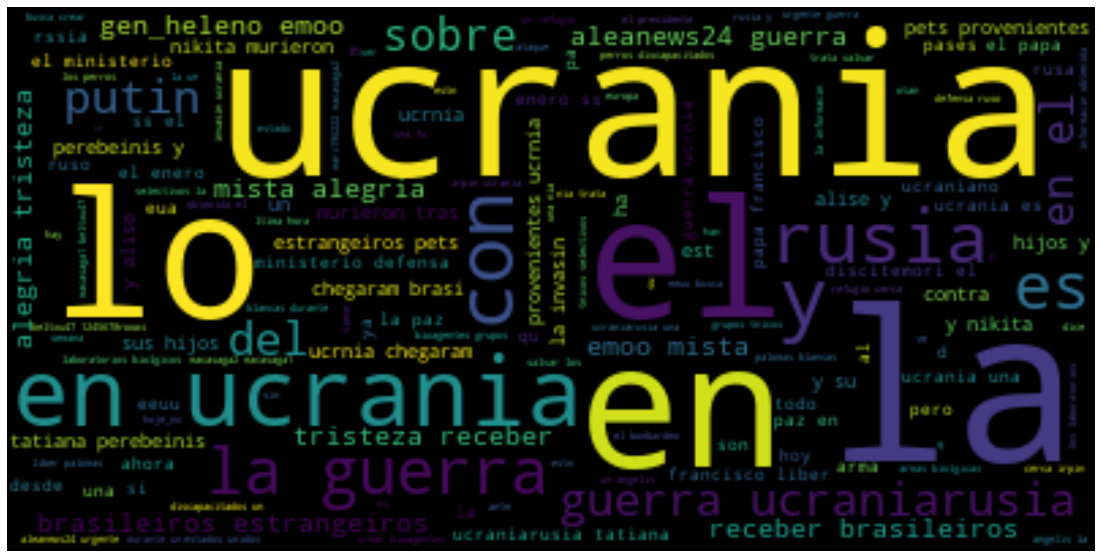

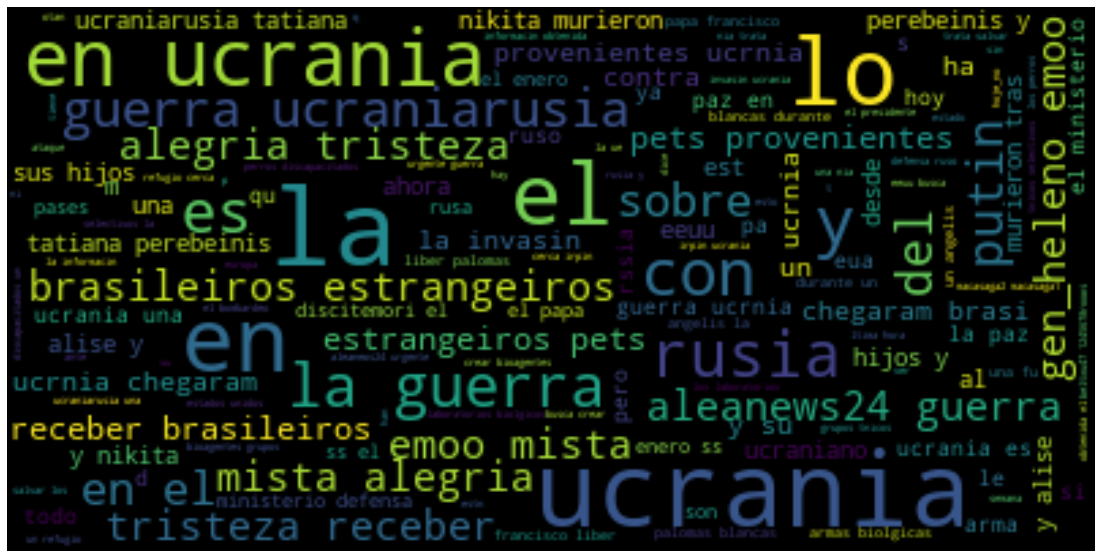

In [31]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text'] + ' '
        
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")
stext = stext.replace("tco","")
stext = stext.replace("rt","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [32]:
words = stext.split()

In [33]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

la
ucrania
en
el
y
los
guerra
un
ucrnia
rusia
una
con
las
es
del
lo
al
putin
brasileiros
aleanews24:
sus
est
ucraniarusia:
sobre
su
ha
armas
eeuu
ruso
emoo
receber
estrangeiros
pets
gen_heleno:
mista
alegria
tristeza
provenientes
chegaram
brasi


In [34]:
for i in range(15):
    print (c.popitem())

('elamerican_', 1)
('/pv2qw886hx', 1)
('orlvndoa', 1)
('sacrificar', 1)
('estupideces', 1)
('defender', 1)
('carlosgomezpy', 1)
('/zdhks4jn9t', 1)
('"espa', 1)
('tirando', 1)
('dizem', 1)
('patavina', 1)
('percebo', 1)
('possa', 1)
('228meo', 1)


## colocando as palavras e suas frequencias do twitter num dataframe

In [35]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

,Word,Frequency
0,la,542
1,ucrania,514
2,en,453
3,el,423
4,y,336
5,los,204
6,guerra,199
7,un,164
8,ucrnia,153
9,rusia,147


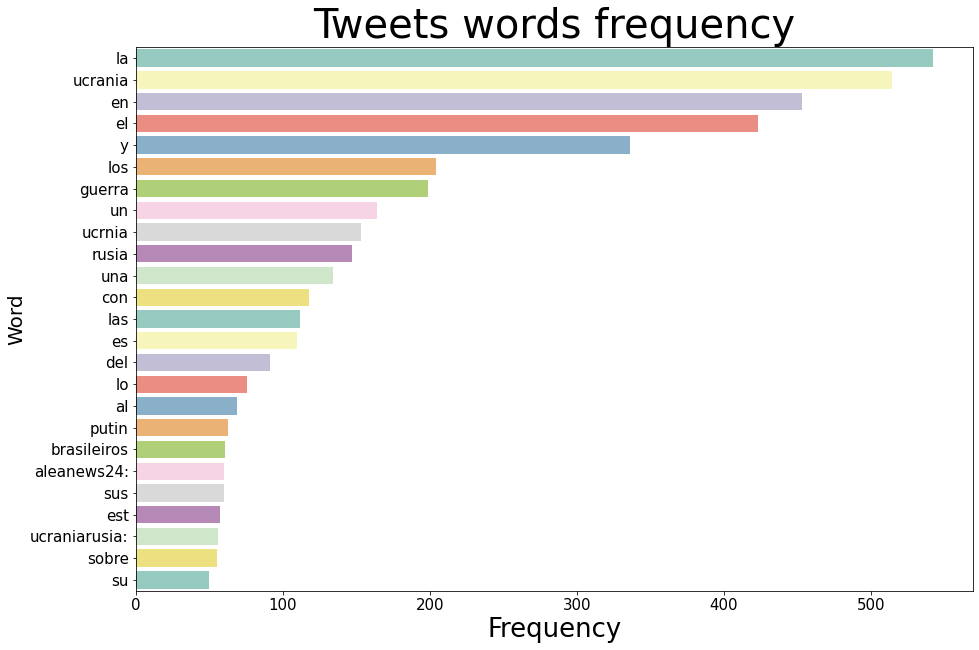

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [37]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

3
{'Spain', 'Turkey', 'Portugal'}


In [38]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

430

In [39]:
for i in range(15):
    print(location.pop())


Córdoba, Argentina
Buenos Aires 
Conurbano
Zona 10
Otavalo, Ecuador
Vallekas
Cdad Guayana/Venezuela
Murcia
Brasil
Occidente 
Extremadura, España
Entre Macondo y Gulch
Belém
Monterrey, Nuevo León


## contar a ocorrencia de cada cidade

In [40]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [41]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

,city,frequency
0,"Valencia, España",1
1,De volta em 🇧🇷,1
2,Madrid,1
3,"Kyoto, Japan",1
4,Roquetas de Mar,1
5,"Hogar, dulce hogar!",1
6,Santa Fe / Argentina,1
7,"Miranda, Venezuela",1
8,"Casco Histórico de Vallecas, Madrid",1
9,MX,1


C:\Users\valen\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 127463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\valen\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\valen\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 127463 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\valen\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0, flags=flags)


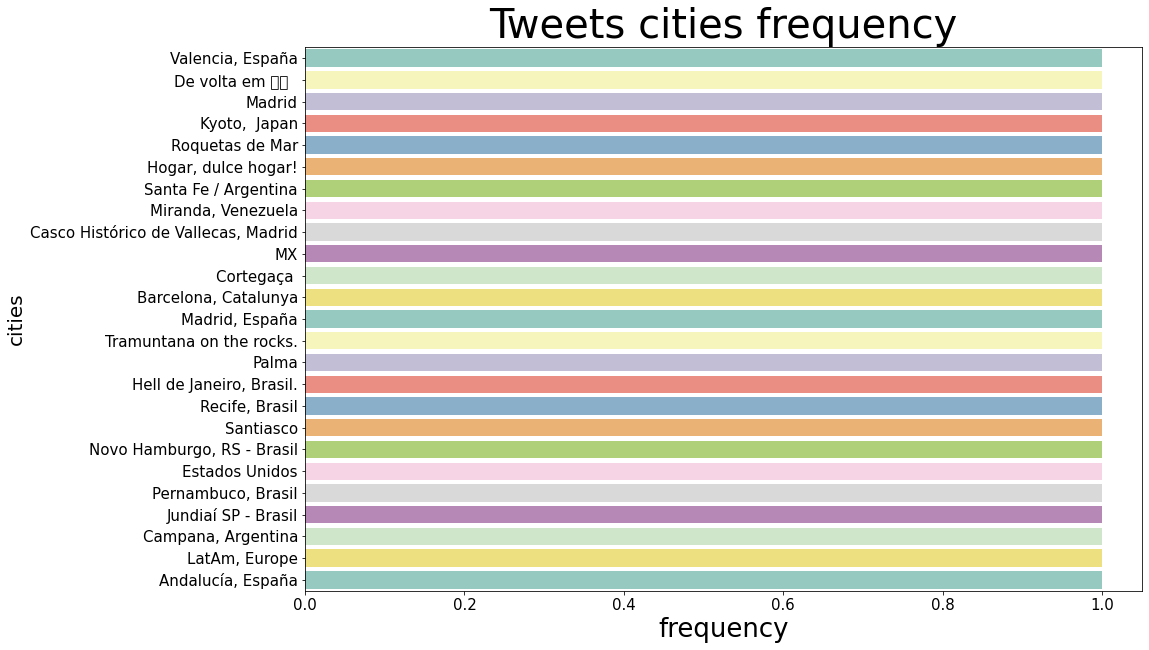

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [43]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [44]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

3


In [45]:
len(tweets_com_coordenadas)/len(results) * 100

0.27272727272727276

In [46]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'type': 'Polygon',
 'coordinates': [[[28.6205846, 40.9992989],
   [28.7019206, 40.9992989],
   [28.7019206, 41.0985943],
   [28.6205846, 41.0985943]]]}

In [47]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[28.6205846, 40.9992989],
  [28.7019206, 40.9992989],
  [28.7019206, 41.0985943],
  [28.6205846, 41.0985943]]]

In [48]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[28.6205846, 40.9992989]

In [49]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [50]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[28.6205846, 40.9992989], [1.9437494, 41.5171401], [-8.6960823, 40.7957344]]

In [51]:
len(tweets_com_coordenadas)

3

In [52]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [53]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

3

In [54]:
print(list(latitudes_tweets[:15]))

[40.9992989, 41.5171401, 40.7957344]


In [55]:
print(list(longitudes_tweets[:15]))

[28.6205846, 1.9437494, -8.6960823]


In [56]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

,latitude,longitude
0,40.999299,28.620585
1,41.517140,1.943749
2,40.795734,-8.696082


In [57]:
len(df10)

3

In [58]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

3

In [59]:
df11.to_csv('coordenadas-tweets.csv', index=False)

In [60]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets.csv')
df11.head()

,latitude,longitude
0,40.999299,28.620585
1,41.517140,1.943749
2,40.795734,-8.696082


In [61]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

latitude: 40.9992989 , longitude: 28.6205846
latitude: 41.5171401 , longitude: 1.9437494
latitude: 40.7957344 , longitude: -8.6960823


In [62]:
print(list(latitudes_tweets[:10]))

[40.9992989, 41.5171401, 40.7957344]


In [63]:
print(list(longitudes_tweets[:10]))

[28.6205846, 1.9437494, -8.6960823]


## ler coordenadas de um arquivo

In [64]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

,latitude,longitude
0,40.802734,28.632104
1,19.826460,-84.952008


In [65]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

,latitude,longitude
0,40.802734,28.632104
1,19.826460,-84.952008


## remover tuplas duplicadas

In [66]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

2

# Georeferenciar os tweets no mapa mundi

In [69]:
#!pip install folium

In [70]:
tweets_coordenadasXY

[[28.6205846, 40.9992989], [1.9437494, 41.5171401], [-8.6960823, 40.7957344]]

In [71]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'


folium.Map.save(mapit, "index.html")


mapit

# twitter trends - assuntos mais comentados do momento

In [72]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [73]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [74]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

topicos mais comentados: Mundo 2022-03-10 17:29:48.219942
#ZemmourVsPecresse
#GNTM
BASEBALL IS BACK
Chelsea
Mets
#FaceAFaceTF1LCI
#BarcavGS
#LilDurk
CAMBIOS DE LUNA
Norwich
Michigan
Grimes
Wordle 265 X
Rodrigo
Cawthorn
Lastarria
Jeff Passan
Syracuse
PLAY BALL
Freddie Freeman
Umstyling
Mario
phoebe
Scherzer
Galatasaray
Castilla
Mason Mount
Chris Wood
Lindor
Mike White
Juwan Howard
Ryan Coogler
Texas A&M
Taylan
Raymond
Forshaw
Babel
Indiana
Providence
Petrobras
DuckDuckGo
Munir
Delphine
kauana
最新ツイート
Carlos Correa
Ted Cruz
第49回
Viola
Traore


In [75]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

topicos mais comentados: USA 2022-03-10 17:30:22.278438
BASEBALL IS BACK
Mets
#LilDurk
Michigan
Correa
#iubb
#MAR10Day
Cawthorn
Freddie Freeman
PLAY BALL
Passan
Syracuse
Grimes
phoebe
Scherzer
Mike White
Juwan Howard
Texas A&M
#LFGM
Mario
Providence
Indiana
Ryan Coogler
Kris Bryant
#overwatch2
jimmy boeheim
Chelsea
Jeremy Roach
Aggies
Hoosiers
Ted Cruz
Jussie Smollett
Chris Beard
DuckDuckGo
Boras
Heyman
Collins
Mike Woodson
Norwich
Jason Williams
Ingold
niki
Northwestern
Ben Simmons
Marcus Carr
Hassan Diarra
Bank of America
Joe Girard
Martelli
Trey Flowers


In [76]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

topicos mais comentados: Brasil 2022-03-10 17:30:33.698897
RODRIGO E JADE NA REPESCAGEM
Petrobras
kauana
PROMO JADEJADE
Dummy
Grimes
#CiroTemRazao
Crocs
Boninho
#EuropaLeagueNaESPN
Júnior Moraes
Chelsea
Lucas Piazon
#gasolina
LOS GRANDES NO GAULES
Ana Clara
Dummie
Carla Diaz
CLAY MOSS
Liniker
Atalanta
Gabriel Monteiro
ICMS
Overwatch 2
#GoRED
Galatasaray
Camilla
Flopou
#SemanticErrorEP8
Elon Musk
NOAH URREA
VISCA BARÇA
Aston Villa
Lady Gaga
Stitch
Senado
Lolla
Tata Werneck
Rammstein
Requião
Leverkusen
Sevilla
stefan
Rekkon
kehlani
Luisa Mell
Ibaneis
VEM AI NAVIO DO LUAN
Metal Lords
alessia


In [77]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

topicos mais comentados: UK
Coutinho
Lanzini
IPTV
#RadheShyam
#UECL
#womaninbizhour
#MoonKnight
Rudiger
Stamford Bridge
Saudi
DuckDuckGo
Elon Musk
Mike Ashley
Lavrov
Broja
Nike
Prince William
Kante
Chelsea
McGregor
Rodrigo
Norwich
Whitney
Gray
Chris Wood
Forshaw
Shirley
Fornals
Krafth
Murphy
Shelvey
Dan James
ayling
Mings
Vlasic
Sevilla
PENALTY TO RANGERS
Douglas Ross
Dallas
Ally McCoist
Mitch
Jake Connor
Kush
Mason Mount
Ben Foster
Scraps
Karen
Clayton
Koch


In [78]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

topicos mais comentados: São Paulo
Cavani
Suarez
#OClone
Emicida
coreia do sul
Florence
#Shopee153
Miley Cyrus
remus
Ferrari
RODRIGO E JADE NA REPESCAGEM
Petrobras
Dummy
kauana
PROMO JADEJADE
Grimes
#CiroTemRazao
Crocs
Boninho
#EuropaLeagueNaESPN
Júnior Moraes
Chelsea
Lucas Piazon
LOS GRANDES NO GAULES
#gasolina
Ana Clara
Dummie
Carla Diaz
CLAY MOSS
Liniker
Overwatch 2
ICMS
Gabriel Monteiro
Atalanta
Galatasaray
Camilla
Flopou
Elon Musk
NOAH URREA
Aston Villa
Lady Gaga
VISCA BARÇA
Stitch
Lolla
Tata Werneck
Senado
Rammstein
Leverkusen
Sevilla
Requião


# Análise de Sentimentos - Tweets

In [ ]:
#!pip install textblob
#!python -m pip install --pre googletrans

In [ ]:
#!pip install googletrans
#!pip install google_trans_new

In [ ]:
#!pip install googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
translator = Translator()

#translator.translate('veritas lux mea', src='la')
translator.translate('oi, tudo bem', src='pt').text #, src='pt', dest='en') 

### Testando as polaridades

In [ ]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

In [ ]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

In [ ]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

# polaridade de tweets em ingles e portugues

In [ ]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
        if language == 'br' or language == 'pt' :
            text_en = translator.translate(text_tweet, src='pt').text  
            analysis = tb(text_en)
        elif language == 'en':   
            analysis = frase
        else:
            analysis = ""
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [ ]:
q = 'tesla'

"""
mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100
"""

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    #print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

In [ ]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

### gravando os dados do dataframe num arquivo .csv

In [ ]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [ ]:
df.loc[:, ['name', "%pos", "%neg" ]]